In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9,9)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
torch.manual_seed(0)
import scipy.signal as sp
from torch.utils.data import TensorDataset

![simpleresnet.png](simpleresnet.png)

This exercies uses a simple implementation of a deep neural network to explore the vanishing gradient problem

We have provided an example of a very simple feed forward network that has a strongly vanishing gradient w.r.t. the weights that are increasingly close to the input end. 

Your job is to modify the network so that it uses skip connections and make observations on what happens to the gradient after. 

Text(0, 0.5, 'Weight Gradients')

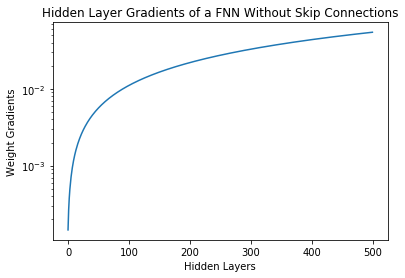

In [2]:
# Choose an activation function
activation = torch.tanh

# Choose a number of iterations
n = 500


# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.tensor([1])

# Initial value
x = torch.tensor([1.],requires_grad=True)

z_prev = x

# Loop over a number of hidden layers
for i in range(n):
    # New weight
    w_i = torch.tensor([1.],requires_grad=True)

    # Linear transform
    a_i = z_prev*w_i

    # Activation
    zprime_i = activation(a_i)

    
    z_i = zprime_i
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
    a_list.append(a_i)

    # output of layer i becomes input for layer i+1
    z_prev = z_i

# Objective function
L = torch.sqrt((z_i - z_obs)**2)

# Reverse-mode AD
L.backward(retain_graph = True)

# Print each weight's gradient
w_grad_init = []

#w_list.reverse()
for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad_init.append(grad)
    
plt.semilogy(w_grad_init)
plt.title('Hidden Layer Gradients of a FNN Without Skip Connections')
plt.xlabel('Hidden Layers')
plt.ylabel('Weight Gradients')

Text(0, 0.5, 'Weight Gradients')

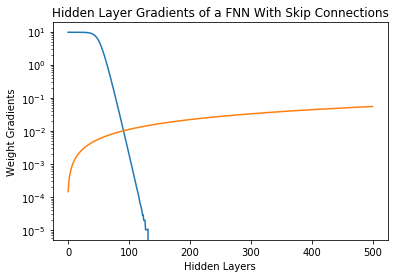

In [3]:
# Store the feed-forward steps
w_list = []
z_list = []
a_list = []

# Make up some data
z_obs = torch.randn((1,))
# Initial value
x =torch.tensor([.1],requires_grad=True)
z_prev = x
# Loop over a number of hidden layers


#how many layers we skip
skip1 = 2
skip2 = 3

activation = torch.tanh
   
for i in range(1,n+1):
    # New weight
    w_i = torch.tensor([.1],requires_grad=True)
   
    # Linear transform
    a_i = w_i*z_prev 

    # Activation
    zprime_i = activation(a_i) 

    # TODO: replace the line below with one that would add a skip connection use the .add(tensor) method   
    z_i = zprime_i + z_prev
    # think about how we would skip multiple layers using MULTIPLE skip lengths in this instance (hint, use branching and the modulus operator)
    
    # We found the results to be VERY non-linear
 
    
    # Store forward model stuff
    w_list.append(w_i)
    z_list.append(z_prev)
    a_list.append(a_i)
    # output of layer i becomes input for layer i+1
    z_prev = z_i

# Objective function
L = torch.sqrt((z_i - z_obs)**2)

# Reverse-mode AD
L.backward(retain_graph = True)

# Print each weight's gradient
w_grad = []

#w_list.reverse()
for i in range(len(w_list)):
    grad = torch.abs(w_list[i].grad).tolist()[0]
    w_grad.append(grad)

#w_grad = sp.savgol_filter(w_grad,5,3)
plt.semilogy(w_grad,label='Skip Connections')
plt.semilogy(w_grad_init,label='No Skip Connections') #compare to previous network
plt.title('Hidden Layer Gradients of a FNN With Skip Connections')
plt.xlabel('Hidden Layers')
plt.ylabel('Weight Gradients')


Now that we have seen how implementing skip connections seemingly solve the problem of vanishing gradients, we've learned all we can from the paper, lets look at some applications

------------

Below is a simple example of an image processing problem where vanishing gradient becomes an issue (no need to show it this time)

For training and testing data I generated random images for a training and test set. If the small problems are too easy feel free to increase the size of the datasets to make for more challenging problems

After you get done with the conceptual questions below, feel free to change the architecture of the below net. Make 3 changes to the architecture, record the loss difference after 100 iterations, and come up with a justification for that difference in loss

Now we will run an implemenation of a simple deep convolutional network on MNIST (handwritten numbers)

In [4]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_data = train_dataset.data[::20].unsqueeze(1).float()
train_targets = train_dataset.targets[::20].unsqueeze(1)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_data = test_dataset.data[::20].unsqueeze(1).float()
test_targets = test_dataset.targets[::20].unsqueeze(1)

training_data = TensorDataset(train_data,train_targets)
testing_data = TensorDataset(test_data,test_targets)

train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                          batch_size=100,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=100,
                                          shuffle=False)



This model allows you to input a specified number of convolutional layers in your network.

In [5]:
# basic net class
class Net(nn.Module):
    def __init__(self, num_input_images, num_layers):
        
        # batch size is needed to configure 
        self.num_input_images = num_input_images
        self.num_layers = num_layers
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        self.linearization2 = nn.Linear(5*26*26,10)
        self.convout = nn.Conv2d(1, 5, 3)
        self.linears = nn.ModuleList([nn.Linear(28,28)])
        self.linears.extend([nn.Linear(28, 28) for i in range(1, self.num_layers-1)])
        
    
    def forward(self, x):
        ### Hint, you can store the input x here
        zprev = x
        # convolution
        self.conv1(zprev)
        for i in range(1,self.num_layers-1): #loops over a set number of blocks conv to relu
            
            x = self.linears[i](zprev)
            zi = F.relu(x)
            zprev = zi
    
            
        x = self.convout(zi)
        # outputed images needed to be flattened for a linear layer
        x = x.view(self.num_input_images, 5*26*26)
        # find linear patterns in non-linear data
        x = self.linearization2(x)
        return x    


In [6]:
def train_model(epic, your_net):
        train_accuracy = []
        test_accuracy = []
        
        model = your_net
        model.to(device)

        criterion = torch.nn.CrossEntropyLoss() #since ive set this up as a classification problem with bins number of classes

        optimizer = torch.optim.Adam(model.parameters())

        epochs = epic
        # Loop over the data

        for epoch in range(epochs):
                model.train()
                # Loop over each subset of data

                correct = 0
                total = 0        

                for d,t in train_loader:
                        # Zero out the optimizer's gradient buffer
                        optimizer.zero_grad()
                        # Make a prediction based on the model
                        outputs = model(d)
                        # Compute the loss
                        loss = criterion(outputs,t[:,0])
                        # Use backpropagation to compute the derivative of the loss with respect to the parameters
                        loss.backward()
                        # Use the derivative information to update the parameters
                        optimizer.step()

                        
                        _, predicted = torch.max(outputs.data, 1)
                        correct += len(predicted[predicted==t[:,0]])
                        total += len(predicted.flatten())
                                
                correcttest = 0
                totaltest = 0        

                for d,t in test_loader:
                
                    outputs = model(d)
                    _, predicted = torch.max(outputs.data, 1)
                    correcttest += len(predicted[predicted==t[:,0]])
                    totaltest += len(predicted.flatten())
                
                if epoch%10==0:      
                        print(epoch,loss.item(), ' Train_Accuracy = ', correct/total*100,' Test_Accuracy = ', correcttest/totaltest*100)
                
                train_accuracy.append(correct/total*100)
                test_accuracy.append(correcttest/totaltest*100)
        
        return train_accuracy, test_accuracy

You can mess with these paramenters and see how your model performance changes

In [7]:
num_input_images = 100
num_classes = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
num_epochs = 50 #how long to run the model
num_layers = 10 #how many convolutions to perform

0 1.1280336380004883  Train_Accuracy =  34.166666666666664  Test_Accuracy =  66.2
10 0.17117942869663239  Train_Accuracy =  92.80000000000001  Test_Accuracy =  88.8
20 0.06987325102090836  Train_Accuracy =  97.13333333333334  Test_Accuracy =  88.8
30 0.09425786882638931  Train_Accuracy =  97.6  Test_Accuracy =  89.60000000000001
40 0.0005215246928855777  Train_Accuracy =  100.0  Test_Accuracy =  89.2


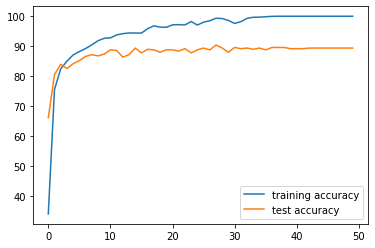

In [8]:
trainacc_init, testacc_init = train_model(num_epochs, Net(num_input_images, num_layers)) #train the model for a hundred epochs

plt.plot(trainacc_init, label = 'training accuracy')
plt.plot(testacc_init, label = 'test accuracy')
plt.legend()
plt.show()

In a similar fashion to what you did on the previous FNN, add skip connects and see if you can improve the model.

In [9]:
# basic net class
skip1 = 2
skip2 = 3


class ResNet(nn.Module):
    def __init__(self, num_input_images, num_layers):
        
        # batch size is needed to configure 
        self.num_input_images = num_input_images
        self.num_layers = num_layers
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, padding = 1)
        #self.linearization1 = nn.Linear(28,28)
        self.linearization2 = nn.Linear(5*26*26,10)
        self.convout = nn.Conv2d(1, 5, 3)
        self.linears = nn.ModuleList([nn.Linear(28,28)])
        self.linears.extend([nn.Linear(28, 28) for i in range(1, self.num_layers-1)])
        
        self.a_list = []
        self.z_list = []
    
    def forward(self, x):
        ### Hint, you can store the input x here
        zprev = x
        # convolution
        self.conv1(zprev)
        for i in range(1,self.num_layers-1): #loops over a set number of blocks conv to relu
            
            #ai = self.linearization(zprev)
          
            ai = self.linears[i](zprev)
            
            # TODO: Implement skip connections in a similar fashion to what was done previously.
            # Think carefully about your skip intervals, and what should be used where
            # hint: use the lists defined as a class object, the modulus operator, and the .add() method
           
            zprime = F.relu(ai)
            zi = zprime + zprev            
            self.z_list.append(zprev)
            self.a_list.append(ai)
            zprev = zi
            
            
        x = self.convout(zi)
        # outputed images needed to be flattened for a linear layer
        x = x.view(self.num_input_images, 5*26*26)
        # find linear patterns in non-linear data
        x = self.linearization2(x)
        return x    


0 14.768957138061523  Train_Accuracy =  49.06666666666666  Test_Accuracy =  73.6
10 0.35601893067359924  Train_Accuracy =  96.6  Test_Accuracy =  84.2
20 0.27389129996299744  Train_Accuracy =  98.23333333333333  Test_Accuracy =  85.6
30 0.09395499527454376  Train_Accuracy =  98.23333333333333  Test_Accuracy =  87.8
40 0.06303180754184723  Train_Accuracy =  98.96666666666667  Test_Accuracy =  87.8


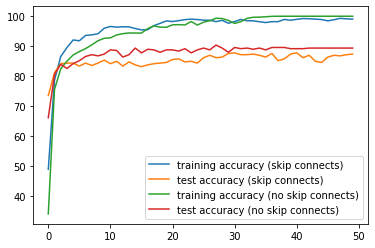

In [10]:
trainacc, testacc = train_model(num_epochs, ResNet(num_input_images, num_layers)) #train the model for a hundred epochs

plt.plot(trainacc, label = 'training accuracy (skip connects)')
plt.plot(testacc, label = 'test accuracy (skip connects)')
plt.plot(trainacc_init, label = 'training accuracy (no skip connects)')
plt.plot(testacc_init, label = 'test accuracy (no skip connects)')
plt.legend()
plt.show()

**Questions**

1. What is the vanishing gradient problem, and what is its primary cause?

The vanishing gradient is when the gradient approaches 0 during the backpropagation process. It is caused by small values of the gradient, values less than 1. If the network is deep, multiplying numbers less than 1 many times will force the gradient to 0.

2. What are 4 limitations to optimizing a deep convolutional neural network?

Some limitations that come with optimizing a deep CNN are vanishing or exploding gradients, memory restrictions and time constraints coming from computationally expensive processes, and overfitting. 

3. In terms of how a given block of a network is "fitted", what is the key difference between using skip connections and traditional blocks?

The main difference between skip connections and traditional blocks is that traditional blocks run inputs through the network from beginning to end whereas skip connections will skip a few blocks by adding the inputs from one layer to the outputs of running those inputs through the layers it has skipped. This method fits the residual.

4. In the context of model hyper-parameters, what additional parameters is added in the res-net implementation?

The only other hyperparameters resnet needs are the skip connections lengths, how many layers will be skipped at a time.

5. How do skip connections resolve the "vanishing gradient" problem? (Open Ended)

I think skip connections resolve the vanishing gradient problem because we are multiplying fewer partial derivatives. Less multiplications gives less opportunity to make the gradient smaller and smaller. 

6. Give an appropriate analogy for how kernels are used to extract features from images (i.e. sanding wood)

Using the sanding wood analogy, sanding the wood gets rid of parts (features) that we are not interested in and extracts features we truly want. This is much like what kernels do. They are applied to the whole image (piece of wood) and extract important or characteristic features that we are interested in, much like sanding reveals parts of the wood that make it distinctive. 

7. Was this a good paper when it was released? Is it a good paper now? What has changed between now and it's initial release point? What other methods are there of solving the vanishing gradient problem? (Open Ended)

I think this paper was probably pretty good when it was released. It introduced a unique idea to a common problem. Now that we have a greater understanding of neural networks I believe the paper lacks in providing a deeper understanding of why the resnet works. It is nice to know that it does work and how it is implemented, but details in why it works would make the paper much better. I haven't seen too many other methods of how to solve the vanishing gradient but I have seen evidence that the LSTM works. It uses a constant error carousel to help solve problems of exploding and vanishing gradients. 

8. What interval of skip connections did you use and where were they applied to? Did you find any #accuracygainz?

I didn't end up being able to implement skip connections where multiple layers were skipped but it did seem like skipping 1 layer at a time did show improvement. 